# Parameter estimation: all
***

**Date**: 25-11-2024<br>

* [x] Add filter by degree of regulation
* [ ] Analyse parameter sensitivity in the model
* [x] Simulate the model with the estimated parameters
* [ ] MLP in `scikitlearn`
* [ ] Increase range in the calibration of $\delta$
* [ ] Use `XGBoost` instead of `scikit-learn` to be able to use the GPU
* [ ] Give more attention to the use attributes!

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pickle

In [2]:
from lisfloodreservoirs import read_attributes#, read_timeseries
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.utils.metrics import compute_performance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 1 Configuration

In [4]:
data_version = {
    'US': 'v2.0',
    'ES': 'v3.0',
    'MX': 'v1.0',
    'BR': 'v1.0',
}

reservoir_model = 'hanazaki_2pars'

data_dir = Path('/eos/jeodpp/home/users/casadje/data')
results_dir = Path('./results/all')
results_dir.mkdir(parents=True, exist_ok=True)

# paths_runs = {
#     'default': data_dir / 'results' / reservoir_model / 'default',
#     'storage': data_dir / 'results' / reservoir_model / 'calibration' / 'storage',
#     'outflow': data_dir / 'results' / reservoir_model / 'calibration' / 'outflow',
#     'bivariate': data_dir / 'results' / reservoir_model / 'calibration' / 'bivariate'
# }

par_range ={
    'alpha': (0.2, 0.99),
    'beta': (0.001, 0.999), 
    'gamma': (0.001, 0.999),
    'delta': (0.1, 0.5),
    'epsilon': (0.001, 0.999),
}

metric = 'KGE'

## 2 Data

### Attributes

In [5]:
rename_attrs = {
    'use_elec': 'hydropower',
    'use_fcon': 'flood',
    'use_fish': 'fish',
    'use_irri': 'irrigation',
    'use_live': 'livestock',
    'use_navi': 'navigation',
    'use_othr': 'other_use',
    'use_pcon': 'pollution',
    'use_recr': 'recreation',
    'use_supp': 'supply',
}

In [6]:
attributes = []
for country, version in data_version.items():

    # load attributes
    path = data_dir / f'ResOps{country}' / version
    attrs = read_attributes(
        path=path / 'attributes',
        reservoirs=pd.read_csv(path / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()
    )
    attrs.columns = attrs.columns.str.lower()
    attrs.rename(columns=rename_attrs, inplace=True, errors='ignore')
    print(country, attrs.shape[0])
    attributes.append(attrs)
# concatenate
attributes = pd.concat(attributes, axis=0).copy()

# degree of regulation (-)
attributes['dor_y'] = np.minimum(attributes.cap_mcm / (attributes.dis_avg_ls * 3600 * 24 * 365 * 1e-9), 100)
attributes.drop(['dor_pc'], axis=1, inplace=True, errors='ignore')

# degree of disruptivity (m)
attributes['dod_m'] = attributes.cap_mcm / attributes.catch_skm

print('all', attributes.shape[0])

US 123
ES 130
MX 59
BR 48
all 360


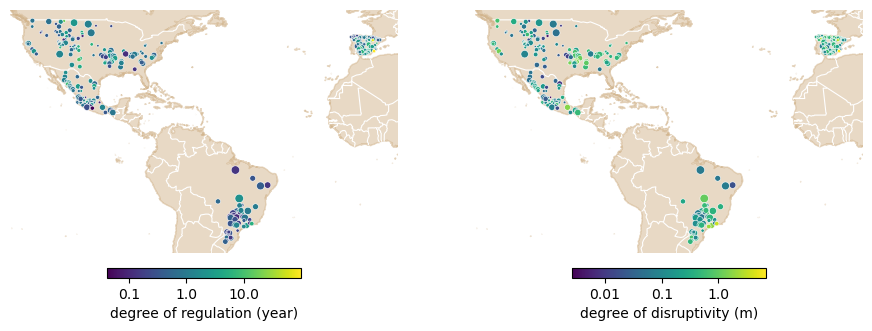

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
labels = {'dor_y': 'degree of regulation (year)', 'dod_m': 'degree of disruptivity (m)'}
for ax, var in zip(axes, labels):
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
    ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
    sct = ax.scatter(
        attributes.lon,
        attributes.lat,
        s=np.cbrt(attributes.cap_mcm),
        c=np.log10(attributes[var]),
        edgecolor='w',
        lw=.4,
        cmap='viridis',
    )
    cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
    cbar.set_label(labels[var])
    ticks = cbar.get_ticks()[1:-1]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(np.power(10, ticks))
    ax.axis('off');
plt.savefig(results_dir / f'regulation_maps.jpg', dpi=300, bbox_inches='tight')

### Time series

In [8]:
timeseries = {}
for country, version in data_version.items():
    path = data_dir / f'ResOps{country}' / version
    
    # read periods
    with open(path / 'selection' / 'periods.pkl', 'rb') as file:
        periods = pickle.load(file)

    # read time series
    for file in (path / 'time_series').glob('*.nc'):
        ID = file.stem
        if ID in periods:
            ds = xr.open_dataset(file)[['storage', 'inflow', 'outflow']]
            start, end = [periods[ID][f'{x}_dates'][0] for x in ['start', 'end']]
            df = ds.sel(date=slice(start, end)).to_pandas()
            df.storage *= 1e6
            timeseries[int(ID)] = df
print(f'{len(timeseries)} reservoirs with time series')

360 reservoirs with time series


### Runs

In [9]:
results = []
# default reservoir limits
limits_def = pd.DataFrame(dtype=float)
for country, version in data_version.items():
    
    paths_runs = {
        'default': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'default',
        'storage': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'storage',
        'outflow': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'outflow',
        'bivariate': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'bivariate'
    }

    runs = []
    for run, path in paths_runs.items():
        # optimal parameters
        parameters = pd.DataFrame(dtype=float)
        if run == 'default':
            for file in path.glob('*parameters.yml'):
                # reservoir ID
                ID = int(file.stem.split('_')[0])
                # extract alpha
                with open(file, 'r') as f:
                    lims = yaml.safe_load(f)
                limits_def = pd.concat((limits_def, pd.DataFrame({ID: lims}).transpose()), axis=0)
                parameters.loc[ID, 'alpha'] = lims['Vf'] / lims['Vtot']
                if reservoir_model.endswith('5pars'):
                    parameters.loc[ID, 'beta'] = (lims['Vtot'] - lims['Ve']) / (lims['Vtot'] - lims['Vf'])
                    parameters.loc[ID, 'gamma'] = lims['Vmin'] / lims['Vf'] 
                    parameters.loc[ID, 'epsilon'] = lims['Qn'] / lims['Qf']
            parameters['delta'] = 0.30
        else:
            for file in path.glob('*samples.csv'):
                # reservoir ID
                ID = int(file.stem.split('_')[0])
                # extract best sample from the calibration
                samples = pd.read_csv(file)
                mask_cols = samples.columns.str.startswith('par')
                parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
                parvalues.index = [ID]
                parvalues.index.name = 'ID'
                parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
                parameters = pd.concat((parameters, parvalues), axis=0)
        parameters.index.name = 'ID'

        # performance
        performance = pd.DataFrame(dtype=float)
        for file in path.glob('*performance.csv'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract best sample from the calibration
            perf = pd.read_csv(file, index_col='metric')
            perf = perf.loc[[metric], ['storage', 'outflow']]
            perf.index = [ID]
            perf.index.name = 'ID'
            perf.columns = [f'{metric}_{col}' for col in perf.columns]
            performance = pd.concat((performance, perf), axis=0)

        # concat all results
        runs.append(xr.Dataset(pd.concat((parameters, performance), axis=1)).expand_dims(dim={'run': [run]}))

    # merge in a single Dataset
    runs = xr.merge(runs)
    runs = runs.reindex(run=['default', 'storage', 'outflow', 'bivariate'])
    results.append(runs)
results = xr.merge(results)

## 3 Analyse runs

### Correlation & distribution

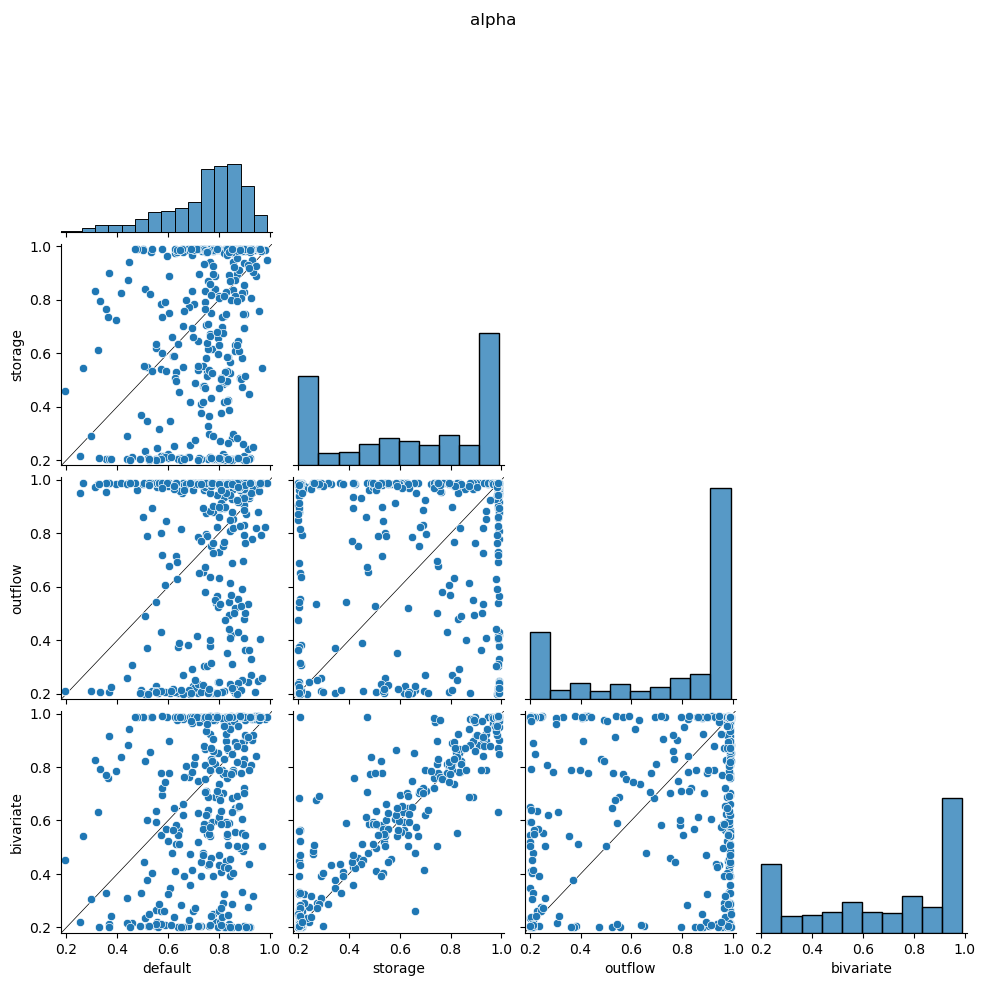

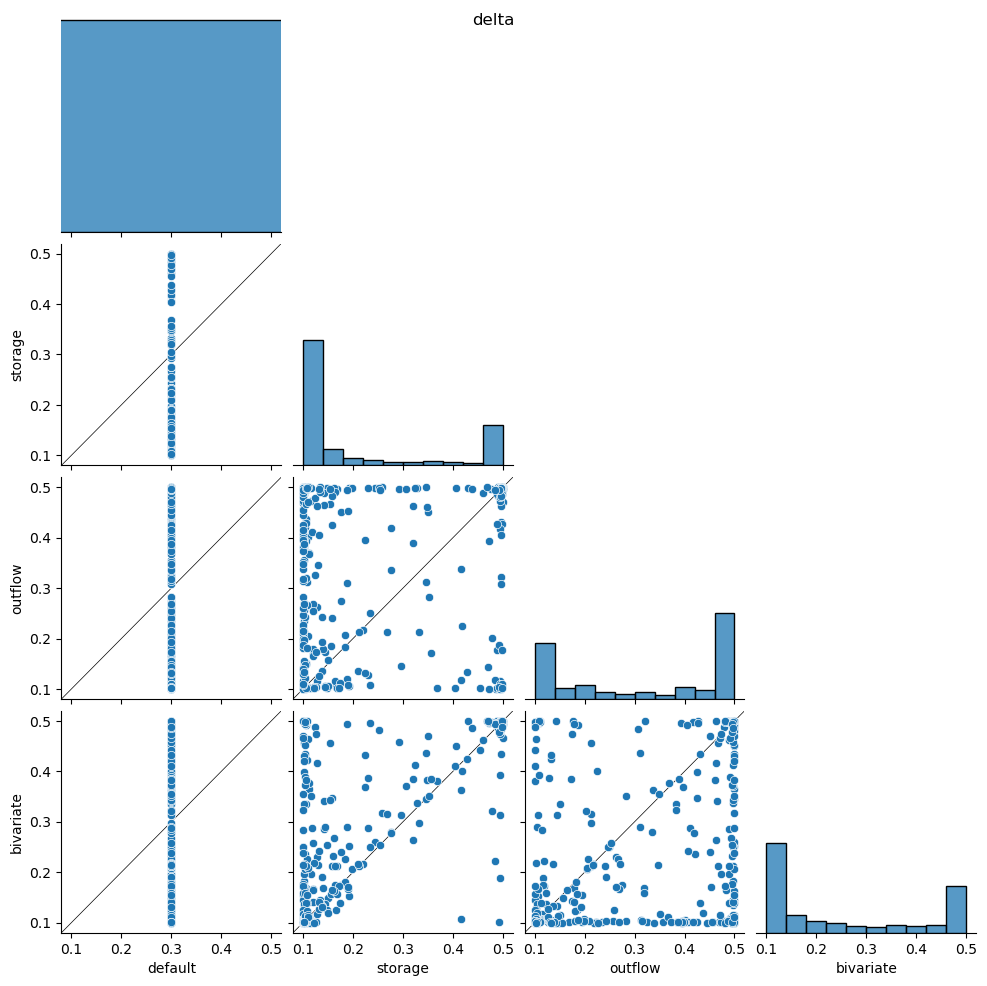

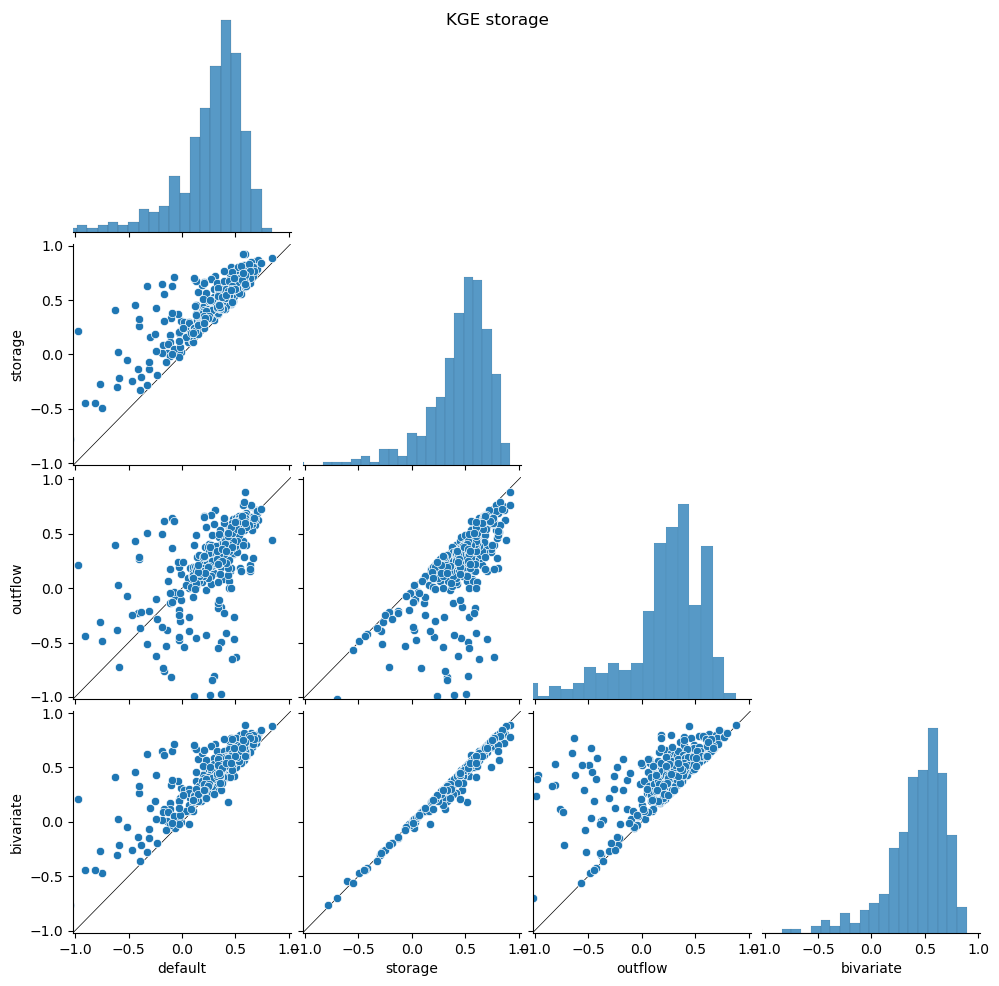

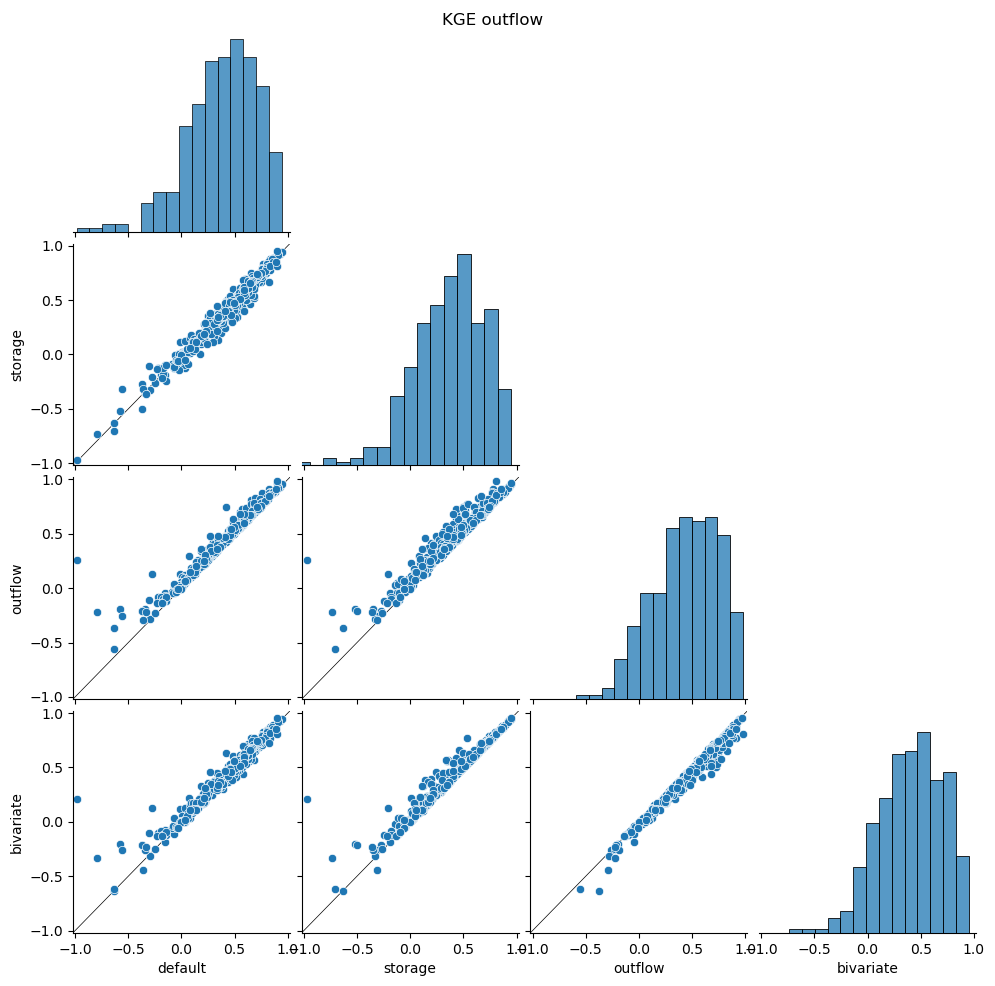

In [10]:
for par, da in results.items():
    pairplot = sns.pairplot(da.to_pandas().transpose(), corner=True)
    pairplot.fig.suptitle(' '.join(par.split('_')))
    if par.startswith('KGE'):
        vlim = (-1.02, 1.02)
    else:
        vlim = [v + e * .02 for v, e in zip(par_range[par], [-1, 1])]
    axes = pairplot.axes
    for i in range(1, axes.shape[0]):
        for j in range(0, axes.shape[1]):
            if j >= i:
                continue
            axes[i,j].plot(vlim, vlim, lw=.5, c='k', zorder=0)
    pairplot.set(
        xlim=vlim,
        ylim=vlim,
    )
    plt.savefig(results_dir / f'{par}_pairplot.jpg', dpi=300, bbox_inches='tight')

### Geographical distribution

#### Performance

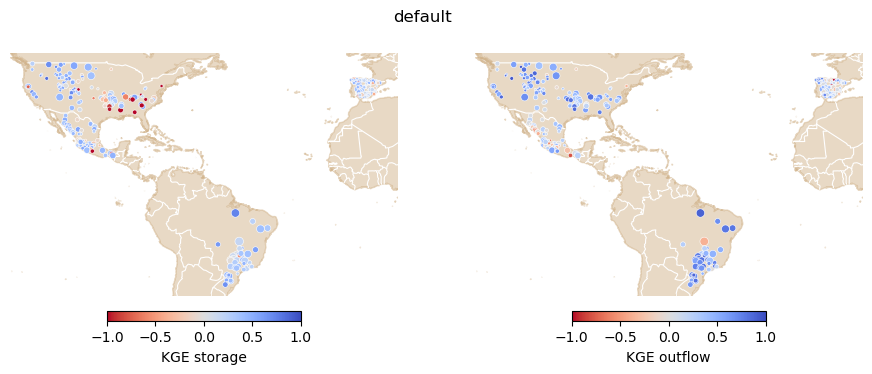

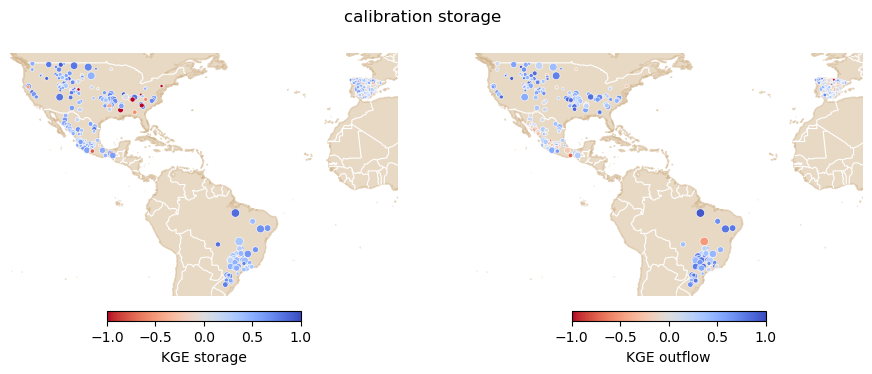

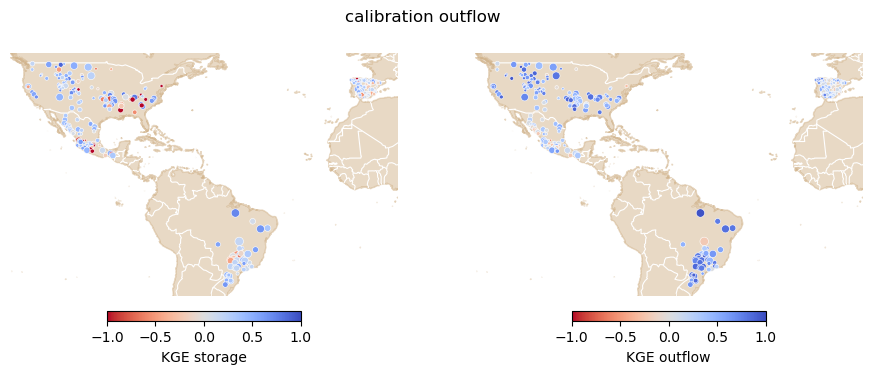

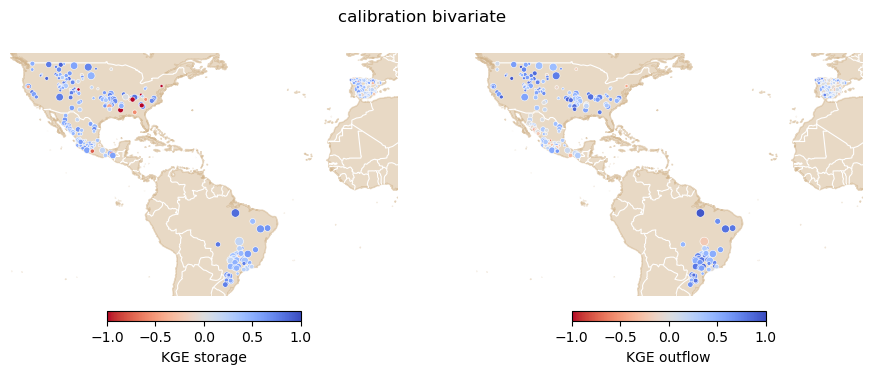

In [11]:
for run in results.run.data: 
    attributes.drop(['alpha', 'delta', 'KGE_storage', 'KGE_outflow'], axis=1, inplace=True, errors='ignore')

    df = results.sel(run=run).to_pandas().drop('run', axis=1)
    df.index.name = 'GRAND_ID'
    attributes = pd.concat((attributes, df), axis=1)

    fig, axes = plt.subplots(ncols=2, figsize=(11, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
    if run == 'default':
        fig.suptitle(run)
    else:
        fig.suptitle(f'calibration {run}')
    for ax, var in zip(axes, ['storage', 'outflow']):
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
        ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
        sct = ax.scatter(
            attributes.lon,
            attributes.lat,
            s=np.cbrt(attributes.cap_mcm),
            c=attributes[f'KGE_{var}'],
            edgecolor='w',
            lw=.4,
            cmap='coolwarm_r',
            norm=mcolors.Normalize(vmin=-1, vmax=1)
        )
        cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
        cbar.set_label(f'KGE {var}')
        ax.axis('off');
    plt.savefig(results_dir / f'performance_maps_{run}.jpg', dpi=300, bbox_inches='tight')

#### Parameter values

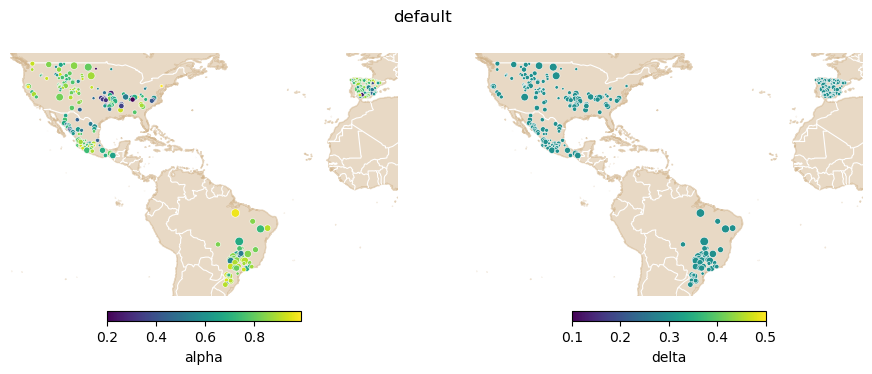

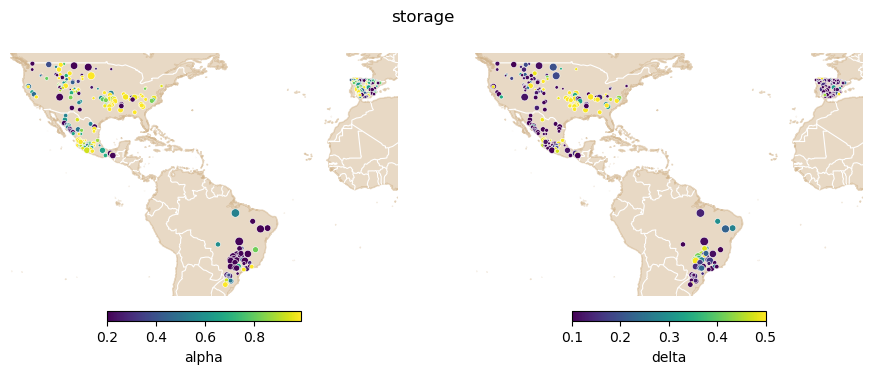

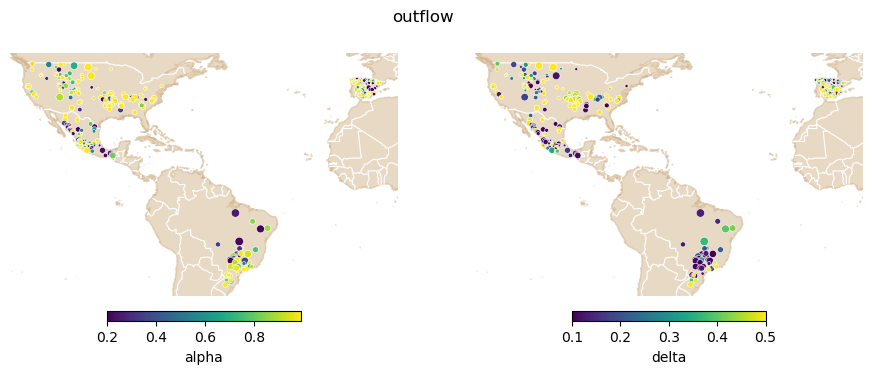

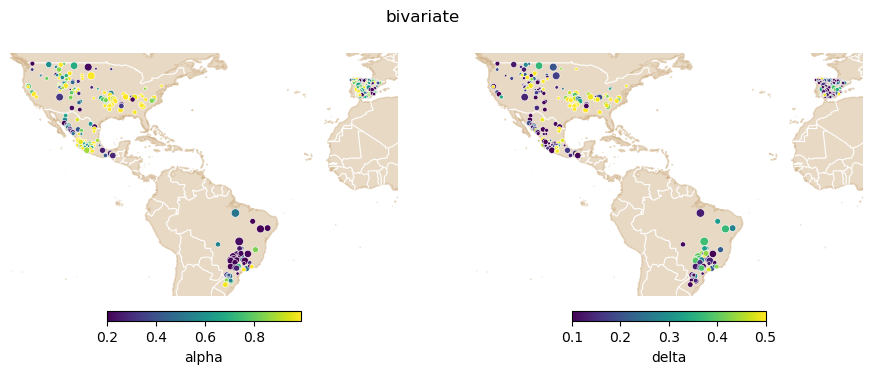

In [12]:
for run in results.run.data: 
    attributes.drop(['alpha', 'delta', 'KGE_storage', 'KGE_outflow'], axis=1, inplace=True, errors='ignore')

    df = results.sel(run=run).to_pandas().drop('run', axis=1)
    df.index.name = 'GRAND_ID'
    attributes = pd.concat((attributes, df), axis=1)

    fig, axes = plt.subplots(ncols=2, figsize=(11, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
    fig.suptitle(run)
    for ax, par in zip(axes, ['alpha', 'delta']):
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
        ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
        sct = ax.scatter(
            attributes.lon,
            attributes.lat,
            s=np.cbrt(attributes.cap_mcm),
            c=attributes[par],
            edgecolor='w',
            lw=.4,
            cmap='viridis',
            norm=mcolors.Normalize(*par_range[par])
        )
        cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
        cbar.set_label(par)
        ax.axis('off');
    plt.savefig(results_dir / f'parameter_maps_{run}.jpg', dpi=300, bbox_inches='tight')

## Models

### Dataset

In [14]:
# select reservoirs
thr = 0.25
mask_storage = attributes.KGE_storage >= thr
mask_outflow = attributes.KGE_outflow >= thr
mask_dor = (attributes.dor_y >= .08)
mask_storage.sum(), mask_outflow.sum(), mask_dor.sum(), (mask_storage & mask_outflow & mask_dor).sum()

(279, 254, 357, 211)

In [18]:
dataset = attributes[mask_storage & mask_outflow & mask_dor].copy()
features = [
    'temp_mean', 'pet_mean', 'precip_mean', 'snow_mean', 'aridity', #'frac_snow', moisture_index', 
    'seasonality', 'high_precip_freq', 'high_precip_dur', 'low_precip_freq', 'low_precip_dur',
    'cap_mcm', 'dam_hgt_m', 'dam_len_m', 'depth_m', 'dor_y', 'dod_m',# 'elev_masl', #'area_skm', 'catch_skm', 'dis_avg_ls', 
    'hydropower', 'flood', 'fish', 'irrigation', 'livestock', 'navigation', 'pollution', 'recreation','supply', #, 'other_use'
    # 'lat', 'lon',
]
targets  = ['alpha', 'delta']

# select features and targets
X, y = dataset[features].copy(), dataset[targets].copy()
# remove features without variation
X.drop(X.columns[X.std() == 0], axis=1, inplace=True)

# split samples
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((147, 23), (64, 23))

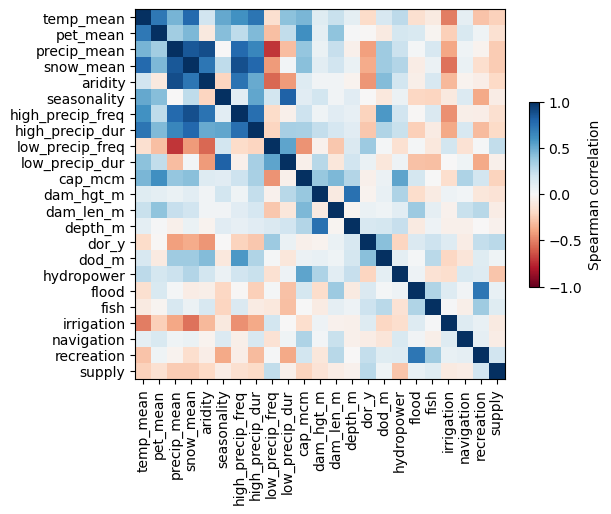

In [19]:
cm = X_train.corr(method='spearman')
im = plt.imshow(cm, cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.yticks(range(X_train.shape[1]), X_train.columns)
cbar = plt.colorbar(im, pad=.05, shrink=.5)
cbar.set_label('Spearman correlation')

### Median

In [16]:
# y_pred = np.median(y_train, axis=0) * len(y_test)
# print('RMSE = {0:.3f}'.format(root_mean_squared_error(y_test, y_pred)))

### Linear regression

In [17]:
# lr = LinearRegression().fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print('RMSE = {0:.3f}'.format(root_mean_squared_error(y_test, y_pred)))

### Random forest univariate

In [20]:
path_rf1 = results_dir / 'random_forest_1'
path_rf1.mkdir(exist_ok=True)

#### Fit model

In [21]:
param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    # verbose=2
)
rf1 = {}
for par in y_train.columns:
    grid_search.fit(X_train, y_train[par])
    model = grid_search.best_estimator_
    print(grid_search.best_params_)
    y_pred = pd.Series(model.predict(X_test), index=X_test.index, name=par)
    rmse = root_mean_squared_error(y_test[par], y_pred)
    print(f'RMSE ({par}) = {rmse:.3f}')
    rf1[par] = model
    # export
    with open(path_rf1 / f'random_forest_{par}.pkl', 'wb') as file:
        pickle.dump(model, file)
pars_rf1 = pd.DataFrame({par: pd.Series(model.predict(X), index=X.index) for par, model in rf1.items()})

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 1000}
RMSE (alpha) = 0.219
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RMSE (delta) = 0.126


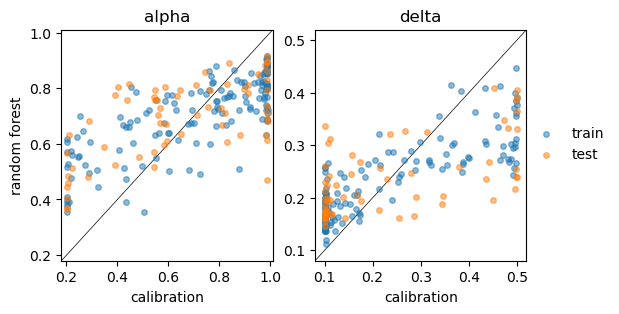

In [22]:
ncols = len(targets)
fig, axes = plt.subplots(ncols=ncols, figsize=(3 * ncols, 3))
for ax, par in zip(axes, targets):
    ax.scatter(
        y_train[par],
        pars_rf1.loc[X_train.index, par],
        c='C0',
        s=16,
        alpha=.5,
        label='train'
    )
    ax.scatter(
        y_test[par],
        pars_rf1.loc[X_test.index, par],
        c='C1',
        s=16,
        alpha=.5,
        label='test'
    )
    vlim = [x + e for x, e in zip(par_range[par], [-.02, .02])]
    ax.plot(vlim, vlim, lw=.5, c='k', zorder=0)
    ax.set(
        xlim=vlim,
        xlabel='calibration',
        ylim=vlim,
        title=par
    )
    if ax == axes[0]:
        ax.set_ylabel('random forest')
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .3, .1, .3]);

plt.savefig(path_rf1 / 'parameter_scatter.jpg', dpi=300, bbox_inches='tight')

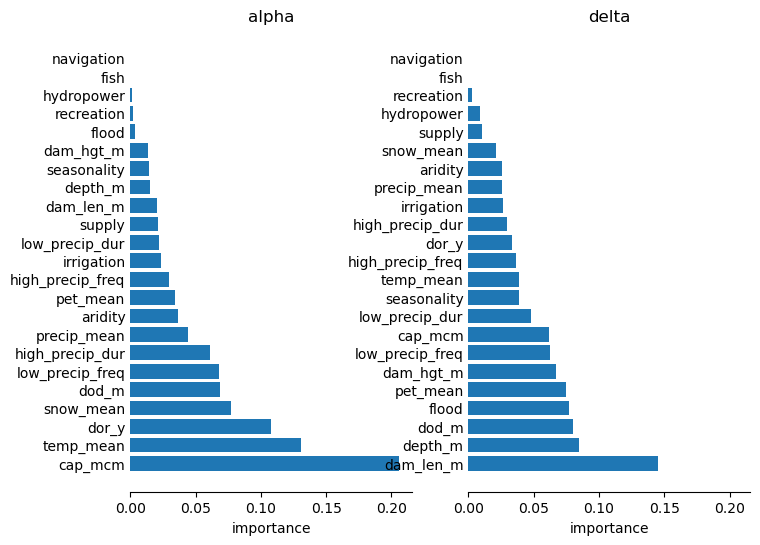

In [23]:
importance_rf1 = pd.DataFrame({par: pd.Series(model.feature_importances_, index=model.feature_names_in_) for par, model in rf1.items()})

fig, axes = plt.subplots(ncols=2, figsize=(8, 6), sharex=True)
for ax, par in zip(axes, targets):
    imp = importance_rf1[par].sort_values(ascending=False)
    ax.barh(imp.index, imp)
    ax.set(
        xlabel='importance',
        title=par
    )
    ax.tick_params(axis='y', length=0)
    ax.spines[['left', 'top', 'right']].set_visible(False)
    
plt.savefig(path_rf1 / 'importance_bar.jpg', dpi=300, bbox_inches='tight')

#### Simulate reservoirs

In [24]:
# adapt limits based on the estimation
limits_rf1 = limits_def.loc[X.index].copy()
limits_rf1.Vf = limits_rf1.Vtot * pars_rf1['alpha']
limits_rf1.Vmin = limits_rf1.Vf * .5
limits_rf1.Ve = limits_rf1.Vtot - .2 * (limits_rf1.Vtot - limits_rf1.Vf)
limits_rf1.Qf *= pars_rf1['delta'] / 0.3

performance_rf1 = pd.DataFrame(columns=['storage', 'outflow'])
for ID, row in limits_rf1.iterrows():
    
    # declare reservoir
    attrs = {attr: row[attr] for attr in ['Vmin', 'Vf', 'Ve', 'Vtot', 'Qn', 'Qf']}
    attrs.update({'A': attributes.loc[ID, 'catch_skm'] * 1e6})
    res = get_model('Hanazaki', **attrs)

    # simulate
    obs = timeseries[ID]
    sim = res.simulate(
        inflow=obs.inflow,
        Vo=obs.storage.iloc[0],
    )

    # analyse performance
    perf = compute_performance(timeseries[ID], sim)
    performance_rf1.loc[ID, :] = perf.loc[metric, performance_rf1.columns].values

# performance_rf1.index.name = 'ID'
performance_rf1.columns = [f'{metric}_{var}' for var in performance_rf1.columns]

  0%|          | 0/2225 [00:00<?, ?it/s]

  0%|          | 0/1865 [00:00<?, ?it/s]

  0%|          | 0/1565 [00:00<?, ?it/s]

  0%|          | 0/2221 [00:00<?, ?it/s]

  0%|          | 0/4346 [00:00<?, ?it/s]

  0%|          | 0/1636 [00:00<?, ?it/s]

  0%|          | 0/4502 [00:00<?, ?it/s]

  0%|          | 0/7578 [00:00<?, ?it/s]

  0%|          | 0/9256 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/8517 [00:00<?, ?it/s]

  0%|          | 0/3279 [00:00<?, ?it/s]

  0%|          | 0/3784 [00:00<?, ?it/s]

  0%|          | 0/3245 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/2349 [00:00<?, ?it/s]

  0%|          | 0/5531 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/9241 [00:00<?, ?it/s]

  0%|          | 0/3766 [00:00<?, ?it/s]

  0%|          | 0/13521 [00:00<?, ?it/s]

  0%|          | 0/11545 [00:00<?, ?it/s]

  0%|          | 0/1516 [00:00<?, ?it/s]

  0%|          | 0/4107 [00:00<?, ?it/s]

  0%|          | 0/7679 [00:00<?, ?it/s]

  0%|          | 0/6662 [00:00<?, ?it/s]

  0%|          | 0/6686 [00:00<?, ?it/s]

  0%|          | 0/2146 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/7663 [00:00<?, ?it/s]

  0%|          | 0/7015 [00:00<?, ?it/s]

  0%|          | 0/3301 [00:00<?, ?it/s]

  0%|          | 0/7884 [00:00<?, ?it/s]

  0%|          | 0/2991 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/9411 [00:00<?, ?it/s]

  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/9013 [00:00<?, ?it/s]

  0%|          | 0/4808 [00:00<?, ?it/s]

  0%|          | 0/7487 [00:00<?, ?it/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

  0%|          | 0/10955 [00:00<?, ?it/s]

  0%|          | 0/1794 [00:00<?, ?it/s]

  0%|          | 0/8291 [00:00<?, ?it/s]

  0%|          | 0/7687 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/7232 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/2799 [00:00<?, ?it/s]

  0%|          | 0/9945 [00:00<?, ?it/s]

  0%|          | 0/4496 [00:00<?, ?it/s]

  0%|          | 0/3575 [00:00<?, ?it/s]

  0%|          | 0/13521 [00:00<?, ?it/s]

  0%|          | 0/12054 [00:00<?, ?it/s]

  0%|          | 0/10089 [00:00<?, ?it/s]

  0%|          | 0/12054 [00:00<?, ?it/s]

  0%|          | 0/12022 [00:00<?, ?it/s]

  0%|          | 0/2107 [00:00<?, ?it/s]

  0%|          | 0/4478 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/6176 [00:00<?, ?it/s]

  0%|          | 0/11028 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/4795 [00:00<?, ?it/s]

  0%|          | 0/5449 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/7234 [00:00<?, ?it/s]

  0%|          | 0/6869 [00:00<?, ?it/s]

  0%|          | 0/11448 [00:00<?, ?it/s]

  0%|          | 0/5025 [00:00<?, ?it/s]

  0%|          | 0/11448 [00:00<?, ?it/s]

  0%|          | 0/1739 [00:00<?, ?it/s]

  0%|          | 0/12357 [00:00<?, ?it/s]

  0%|          | 0/2433 [00:00<?, ?it/s]

  0%|          | 0/3225 [00:00<?, ?it/s]

  0%|          | 0/2872 [00:00<?, ?it/s]

  0%|          | 0/9183 [00:00<?, ?it/s]

  0%|          | 0/8971 [00:00<?, ?it/s]

  0%|          | 0/1594 [00:00<?, ?it/s]

  0%|          | 0/4244 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/10742 [00:00<?, ?it/s]

  0%|          | 0/13513 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6116 [00:00<?, ?it/s]

  0%|          | 0/5084 [00:00<?, ?it/s]

  0%|          | 0/2099 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6116 [00:00<?, ?it/s]

  0%|          | 0/2902 [00:00<?, ?it/s]

  0%|          | 0/8737 [00:00<?, ?it/s]

  0%|          | 0/7880 [00:00<?, ?it/s]

  0%|          | 0/5478 [00:00<?, ?it/s]

  0%|          | 0/7822 [00:00<?, ?it/s]

  0%|          | 0/5687 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/5566 [00:00<?, ?it/s]

  0%|          | 0/9130 [00:00<?, ?it/s]

  0%|          | 0/5691 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6208 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11139 [00:00<?, ?it/s]

  0%|          | 0/9251 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/8012 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/8145 [00:00<?, ?it/s]

  0%|          | 0/5720 [00:00<?, ?it/s]

  0%|          | 0/9860 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9071 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/7154 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9254 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/8419 [00:00<?, ?it/s]

  0%|          | 0/9071 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9009 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/7154 [00:00<?, ?it/s]

  0%|          | 0/6271 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/5119 [00:00<?, ?it/s]

  0%|          | 0/4458 [00:00<?, ?it/s]

  0%|          | 0/2191 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/9131 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/9108 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/9131 [00:00<?, ?it/s]

  0%|          | 0/4858 [00:00<?, ?it/s]

  0%|          | 0/7670 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/7639 [00:00<?, ?it/s]

  0%|          | 0/5484 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/3860 [00:00<?, ?it/s]

  0%|          | 0/7670 [00:00<?, ?it/s]

  0%|          | 0/2709 [00:00<?, ?it/s]

  0%|          | 0/6188 [00:00<?, ?it/s]

  0%|          | 0/4834 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/8516 [00:00<?, ?it/s]

  0%|          | 0/7950 [00:00<?, ?it/s]

  0%|          | 0/4839 [00:00<?, ?it/s]

  0%|          | 0/7075 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/6512 [00:00<?, ?it/s]

  0%|          | 0/6386 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4984 [00:00<?, ?it/s]

  0%|          | 0/4849 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4849 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4865 [00:00<?, ?it/s]

  0%|          | 0/4873 [00:00<?, ?it/s]

  0%|          | 0/2295 [00:00<?, ?it/s]

  0%|          | 0/4853 [00:00<?, ?it/s]

  0%|          | 0/4895 [00:00<?, ?it/s]

  0%|          | 0/8490 [00:00<?, ?it/s]

  0%|          | 0/4975 [00:00<?, ?it/s]

  0%|          | 0/6700 [00:00<?, ?it/s]

  0%|          | 0/4763 [00:00<?, ?it/s]

  0%|          | 0/4566 [00:00<?, ?it/s]

  0%|          | 0/4961 [00:00<?, ?it/s]

  0%|          | 0/4881 [00:00<?, ?it/s]

  0%|          | 0/8946 [00:00<?, ?it/s]

  0%|          | 0/14007 [00:00<?, ?it/s]

  0%|          | 0/6520 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4963 [00:00<?, ?it/s]

  0%|          | 0/4718 [00:00<?, ?it/s]

  0%|          | 0/4073 [00:00<?, ?it/s]

  0%|          | 0/3412 [00:00<?, ?it/s]

  0%|          | 0/5249 [00:00<?, ?it/s]

  0%|          | 0/3593 [00:00<?, ?it/s]

In [25]:
# add to the calibration results
results_rf1 = pd.concat((pars_rf1, performance_rf1), axis=1)
results_rf1.index.name = 'ID'
results = xr.concat((results, xr.Dataset({col: results_rf1[col] for col in results_rf1.columns}).expand_dims({'run': ['random_forest_1']})), dim='run')

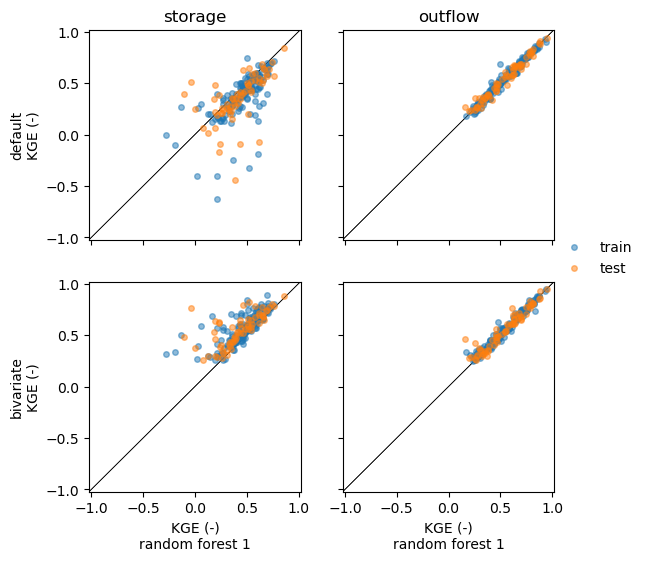

In [26]:
test_run = 'random_forest_1'
runs = ['default', 'bivariate']

fig, ax = plt.subplots(ncols=2, nrows=len(runs), figsize=(6, 3 * len(runs)), sharex=True, sharey=True)
vlim = (-1.02, 1.02)
ax[0, 0].set(
    xlim=vlim,
    ylim=vlim,
)
for i, run in enumerate(runs):
    for j, var in enumerate(['storage', 'outflow']):
        col = f'{metric}_{var}'
        for c, (label, ids) in enumerate({'train': X_train.index, 'test': X_test.index}.items()):
            ax[i, j].scatter(
                results.sel(run=test_run, ID=ids)[f'{metric}_{var}'],
                results.sel(run=run, ID=ids)[f'{metric}_{var}'],
                c=f'C{c}',
                s=16,
                alpha=.5,
                label=label
            )
            ax[i, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
        if i == 0:
            ax[i, j].set_title(var)
        elif i == len(runs) - 1:
            ax[i, j].set_xlabel('KGE (-)\n{0}'.format(' '.join(test_run.split('_'))))
        if j == 0:
            ax[i,j].set_ylabel(f'{run}\nKGE (-)')
        
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .25, .1, .3]);

plt.savefig(path_rf1 / 'performance_scatter.jpg', dpi=300, bbox_inches='tight')

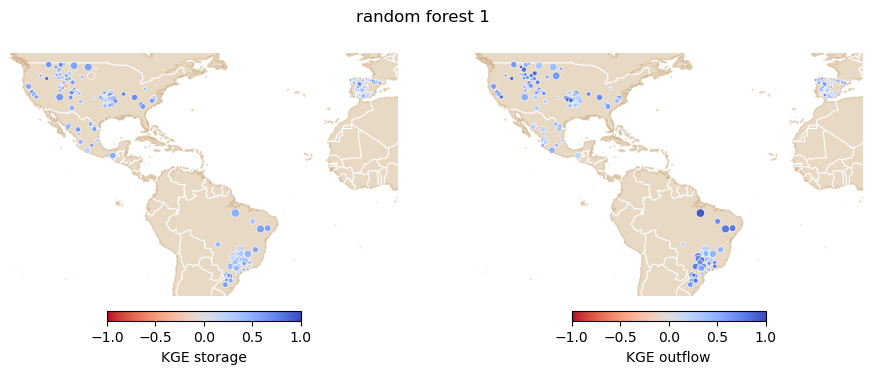

In [27]:
run = 'random_forest_1'

fig, axes = plt.subplots(ncols=2, figsize=(11, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.suptitle(' '.join(run.split('_')))
for ax, var in zip(axes, ['storage', 'outflow']):
    col = f'{metric}_{var}'
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
    ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
    sct = ax.scatter(
        attributes.loc[y.index, 'lon'],
        attributes.loc[y.index, 'lat'],
        s=np.cbrt(attributes.loc[y.index, 'cap_mcm']),
        c=results.sel(run='random_forest_1', ID=y.index)[f'{metric}_{var}'].to_pandas(), #performance_rf1[col],
        edgecolor='w',
        lw=.4,
        cmap='coolwarm_r',
        norm=mcolors.Normalize(vmin=-1, vmax=1)
    )
    cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
    cbar.set_label(f'{metric} {var}')
    ax.axis('off');
plt.savefig(path_rf1 / 'performance_maps.jpg', dpi=300, bbox_inches='tight')

### Random forest bivariate

In [28]:
path_rf2 = results_dir / 'random_forest_2'
path_rf2.mkdir(exist_ok=True)

#### Fit model 

In [29]:
# fit a model that predicts both parameters with the same settings
grid_search.fit(X_train, y_train)
rf2 = grid_search.best_estimator_
print(grid_search.best_params_)
with open(path_rf2 / f'random_forest_2par.pkl', 'wb') as file:
        pickle.dump(rf2, file)

# error
y_pred = pd.DataFrame(rf2.predict(X_test), index=X_test.index, columns=targets)
rmse = {var: root_mean_squared_error(y_test[var], y_pred[var]) for var in y_pred.columns}
for key, value in rmse.items():
    print(f'RMSE ({key}) = {value:.3f}')

# prediction for all samples
pars_rf2 = pd.DataFrame(rf2.predict(X), index=X.index, columns=y.columns)

{'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 1000}
RMSE (alpha) = 0.221
RMSE (delta) = 0.130


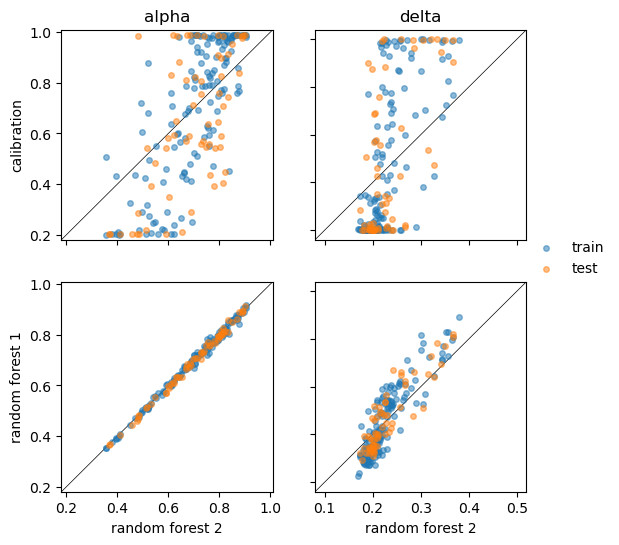

In [30]:
ncols = len(targets)
fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(3 * ncols, 6))
for i, (label, df) in enumerate({'calibration': y, 'random forest 1': pars_rf1}.items()):
    for j, par in enumerate(targets):
        axes[i,j].scatter(
            pars_rf2.loc[X_train.index, par],
            df.loc[X_train.index, par],
            c='C0',
            s=16,
            alpha=.5,
            label='train'
        )
        axes[i,j].scatter(
            pars_rf2.loc[X_test.index, par],
            df.loc[X_test.index, par],
            c='C1',
            s=16,
            alpha=.5,
            label='test'
        )
        vlim = [x + e for x, e in zip(par_range[par], [-.02, .02])]
        axes[i,j].plot(vlim, vlim, lw=.5, c='k', zorder=0)
        axes[i,j].set(
            xlim=vlim,
            ylim=vlim,
        )
        if i == 0:
            axes[0,j].set_title(par)
            axes[0,j].set_xticklabels([])
        elif i == 1:
            axes[1,j].set_xlabel('random forest 2')
        if j == 0:
            axes[i,0].set_ylabel(label)
        else:
            axes[i,j].set_yticklabels([])
        
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .25, .1, .3]);

plt.savefig(path_rf2 / 'parameter_scatter.jpg', dpi=300, bbox_inches='tight')

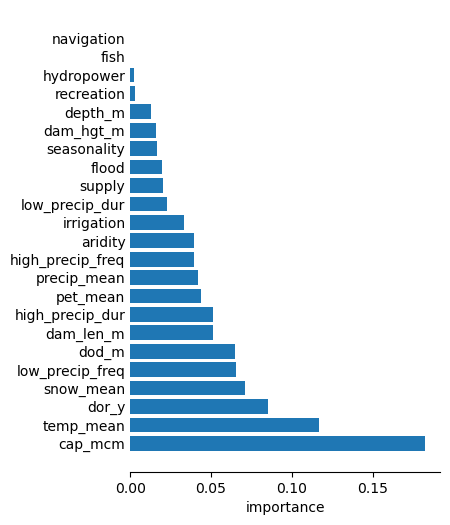

In [31]:
importance_rf2 = pd.Series(rf2.feature_importances_, index=rf2.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(ncols=1, figsize=(4, 6), sharex=True)
ax.barh(importance_rf2.index, importance_rf2)
ax.set_xlabel('importance')
ax.tick_params(axis='y', length=0)
ax.spines[['left', 'top', 'right']].set_visible(False)

plt.savefig(path_rf2 / 'importance_bar.jpg', dpi=300, bbox_inches='tight')

#### Simulate reservoirs

In [32]:
# adapt limits based on the estimation
limits_rf2 = limits_def.loc[X.index].copy()
limits_rf2.Vf = limits_rf2.Vtot * pars_rf2['alpha']
limits_rf2.Vmin = limits_rf2.Vf * .5
limits_rf2.Ve = limits_rf2.Vtot - .2 * (limits_rf2.Vtot - limits_rf2.Vf)
limits_rf2.Qf *= pars_rf2['delta'] / 0.3

performance_rf2 = pd.DataFrame(columns=['storage', 'outflow'])
for ID, row in limits_rf2.iterrows():
    
    # declare reservoir
    attrs = {attr: row[attr] for attr in ['Vmin', 'Vf', 'Ve', 'Vtot', 'Qn', 'Qf']}
    attrs.update({'A': attributes.loc[ID, 'catch_skm'] * 1e6})
    res = get_model('Hanazaki', **attrs)

    # simulate
    obs = timeseries[ID]
    sim = res.simulate(
        inflow=obs.inflow,
        Vo=obs.storage.iloc[0],
    )

    # analyse performance
    perf = compute_performance(timeseries[ID], sim)
    performance_rf2.loc[ID, :] = perf.loc[metric, performance_rf2.columns].values
performance_rf2.columns = [f'{metric}_{var}' for var in performance_rf2.columns]

# add to the calibration results
results_rf2 = pd.concat((pars_rf2, performance_rf2), axis=1)
results_rf2.index.name = 'ID'
results = xr.concat((results, xr.Dataset({col: results_rf2[col] for col in results_rf2.columns}).expand_dims({'run': ['random_forest_2']})), dim='run')

  0%|          | 0/2225 [00:00<?, ?it/s]

  0%|          | 0/1865 [00:00<?, ?it/s]

  0%|          | 0/1565 [00:00<?, ?it/s]

  0%|          | 0/2221 [00:00<?, ?it/s]

  0%|          | 0/4346 [00:00<?, ?it/s]

  0%|          | 0/1636 [00:00<?, ?it/s]

  0%|          | 0/4502 [00:00<?, ?it/s]

  0%|          | 0/7578 [00:00<?, ?it/s]

  0%|          | 0/9256 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/8517 [00:00<?, ?it/s]

  0%|          | 0/3279 [00:00<?, ?it/s]

  0%|          | 0/3784 [00:00<?, ?it/s]

  0%|          | 0/3245 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/2349 [00:00<?, ?it/s]

  0%|          | 0/5531 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/9241 [00:00<?, ?it/s]

  0%|          | 0/3766 [00:00<?, ?it/s]

  0%|          | 0/13521 [00:00<?, ?it/s]

  0%|          | 0/11545 [00:00<?, ?it/s]

  0%|          | 0/1516 [00:00<?, ?it/s]

  0%|          | 0/4107 [00:00<?, ?it/s]

  0%|          | 0/7679 [00:00<?, ?it/s]

  0%|          | 0/6662 [00:00<?, ?it/s]

  0%|          | 0/6686 [00:00<?, ?it/s]

  0%|          | 0/2146 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/7663 [00:00<?, ?it/s]

  0%|          | 0/7015 [00:00<?, ?it/s]

  0%|          | 0/3301 [00:00<?, ?it/s]

  0%|          | 0/7884 [00:00<?, ?it/s]

  0%|          | 0/2991 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/9411 [00:00<?, ?it/s]

  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/9013 [00:00<?, ?it/s]

  0%|          | 0/4808 [00:00<?, ?it/s]

  0%|          | 0/7487 [00:00<?, ?it/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

  0%|          | 0/10955 [00:00<?, ?it/s]

  0%|          | 0/1794 [00:00<?, ?it/s]

  0%|          | 0/8291 [00:00<?, ?it/s]

  0%|          | 0/7687 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/7232 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/2799 [00:00<?, ?it/s]

  0%|          | 0/9945 [00:00<?, ?it/s]

  0%|          | 0/4496 [00:00<?, ?it/s]

  0%|          | 0/3575 [00:00<?, ?it/s]

  0%|          | 0/13521 [00:00<?, ?it/s]

  0%|          | 0/12054 [00:00<?, ?it/s]

  0%|          | 0/10089 [00:00<?, ?it/s]

  0%|          | 0/12054 [00:00<?, ?it/s]

  0%|          | 0/12022 [00:00<?, ?it/s]

  0%|          | 0/2107 [00:00<?, ?it/s]

  0%|          | 0/4478 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/6176 [00:00<?, ?it/s]

  0%|          | 0/11028 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/4795 [00:00<?, ?it/s]

  0%|          | 0/5449 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/7234 [00:00<?, ?it/s]

  0%|          | 0/6869 [00:00<?, ?it/s]

  0%|          | 0/11448 [00:00<?, ?it/s]

  0%|          | 0/5025 [00:00<?, ?it/s]

  0%|          | 0/11448 [00:00<?, ?it/s]

  0%|          | 0/1739 [00:00<?, ?it/s]

  0%|          | 0/12357 [00:00<?, ?it/s]

  0%|          | 0/2433 [00:00<?, ?it/s]

  0%|          | 0/3225 [00:00<?, ?it/s]

  0%|          | 0/2872 [00:00<?, ?it/s]

  0%|          | 0/9183 [00:00<?, ?it/s]

  0%|          | 0/8971 [00:00<?, ?it/s]

  0%|          | 0/1594 [00:00<?, ?it/s]

  0%|          | 0/4244 [00:00<?, ?it/s]

  0%|          | 0/13877 [00:00<?, ?it/s]

  0%|          | 0/10742 [00:00<?, ?it/s]

  0%|          | 0/13513 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6116 [00:00<?, ?it/s]

  0%|          | 0/5084 [00:00<?, ?it/s]

  0%|          | 0/2099 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6116 [00:00<?, ?it/s]

  0%|          | 0/2902 [00:00<?, ?it/s]

  0%|          | 0/8737 [00:00<?, ?it/s]

  0%|          | 0/7880 [00:00<?, ?it/s]

  0%|          | 0/5478 [00:00<?, ?it/s]

  0%|          | 0/7822 [00:00<?, ?it/s]

  0%|          | 0/5687 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/5566 [00:00<?, ?it/s]

  0%|          | 0/9130 [00:00<?, ?it/s]

  0%|          | 0/5691 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6208 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11139 [00:00<?, ?it/s]

  0%|          | 0/9251 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/8012 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/8145 [00:00<?, ?it/s]

  0%|          | 0/5720 [00:00<?, ?it/s]

  0%|          | 0/9860 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9071 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/7154 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9254 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/8419 [00:00<?, ?it/s]

  0%|          | 0/9071 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9009 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/7154 [00:00<?, ?it/s]

  0%|          | 0/6271 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/5119 [00:00<?, ?it/s]

  0%|          | 0/4458 [00:00<?, ?it/s]

  0%|          | 0/2191 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/9131 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/9108 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/9131 [00:00<?, ?it/s]

  0%|          | 0/4858 [00:00<?, ?it/s]

  0%|          | 0/7670 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/7639 [00:00<?, ?it/s]

  0%|          | 0/5484 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/3860 [00:00<?, ?it/s]

  0%|          | 0/7670 [00:00<?, ?it/s]

  0%|          | 0/2709 [00:00<?, ?it/s]

  0%|          | 0/6188 [00:00<?, ?it/s]

  0%|          | 0/4834 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/8516 [00:00<?, ?it/s]

  0%|          | 0/7950 [00:00<?, ?it/s]

  0%|          | 0/4839 [00:00<?, ?it/s]

  0%|          | 0/7075 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/6512 [00:00<?, ?it/s]

  0%|          | 0/6386 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4984 [00:00<?, ?it/s]

  0%|          | 0/4849 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4849 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4865 [00:00<?, ?it/s]

  0%|          | 0/4873 [00:00<?, ?it/s]

  0%|          | 0/2295 [00:00<?, ?it/s]

  0%|          | 0/4853 [00:00<?, ?it/s]

  0%|          | 0/4895 [00:00<?, ?it/s]

  0%|          | 0/8490 [00:00<?, ?it/s]

  0%|          | 0/4975 [00:00<?, ?it/s]

  0%|          | 0/6700 [00:00<?, ?it/s]

  0%|          | 0/4763 [00:00<?, ?it/s]

  0%|          | 0/4566 [00:00<?, ?it/s]

  0%|          | 0/4961 [00:00<?, ?it/s]

  0%|          | 0/4881 [00:00<?, ?it/s]

  0%|          | 0/8946 [00:00<?, ?it/s]

  0%|          | 0/14007 [00:00<?, ?it/s]

  0%|          | 0/6520 [00:00<?, ?it/s]

  0%|          | 0/9861 [00:00<?, ?it/s]

  0%|          | 0/4963 [00:00<?, ?it/s]

  0%|          | 0/4718 [00:00<?, ?it/s]

  0%|          | 0/4073 [00:00<?, ?it/s]

  0%|          | 0/3412 [00:00<?, ?it/s]

  0%|          | 0/5249 [00:00<?, ?it/s]

  0%|          | 0/3593 [00:00<?, ?it/s]

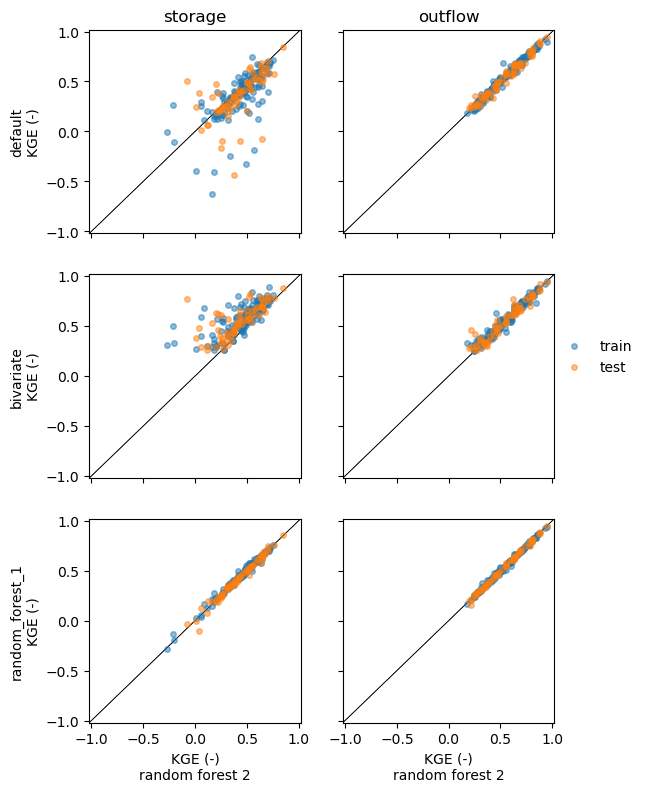

In [33]:
test_run = 'random_forest_2'
runs = ['default', 'bivariate', 'random_forest_1']

fig, ax = plt.subplots(ncols=2, nrows=len(runs), figsize=(6, 3 * len(runs)), sharex=True, sharey=True)
vlim = (-1.02, 1.02)
ax[0, 0].set(
    xlim=vlim,
    ylim=vlim,
)
for i, run in enumerate(runs):
    for j, var in enumerate(['storage', 'outflow']):
        col = f'{metric}_{var}'
        for c, (label, ids) in enumerate({'train': X_train.index, 'test': X_test.index}.items()):
            ax[i, j].scatter(
                results.sel(run=test_run, ID=ids)[f'{metric}_{var}'],
                results.sel(run=run, ID=ids)[f'{metric}_{var}'],
                c=f'C{c}',
                s=16,
                alpha=.5,
                label=label
            )
            ax[i, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
        if i == 0:
            ax[i, j].set_title(var)
        elif i == len(runs) - 1:
            ax[i, j].set_xlabel('KGE (-)\n{0}'.format(' '.join(test_run.split('_'))))
        if j == 0:
            ax[i,j].set_ylabel(f'{run}\nKGE (-)')
        
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .25, .1, .3]);

plt.savefig(path_rf2 / 'performance_scatter.jpg', dpi=300, bbox_inches='tight')

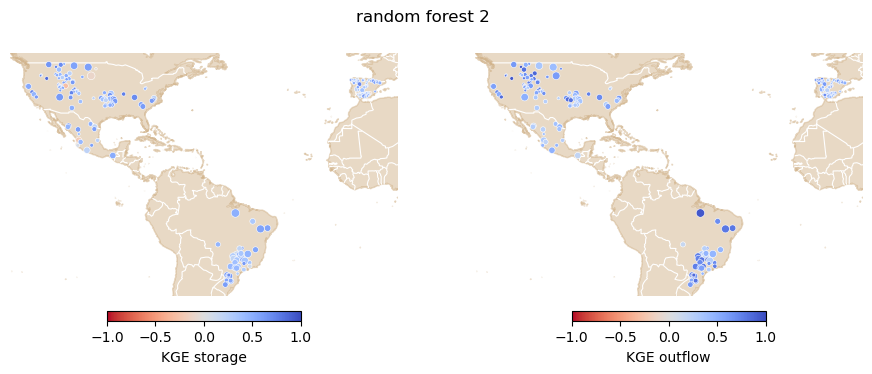

In [34]:
run = 'random_forest_2'

fig, axes = plt.subplots(ncols=2, figsize=(11, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.suptitle(' '.join(run.split('_')))
for ax, var in zip(axes, ['storage', 'outflow']):
    col = f'{metric}_{var}'
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
    ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
    sct = ax.scatter(
        attributes.loc[y.index, 'lon'],
        attributes.loc[y.index, 'lat'],
        s=np.cbrt(attributes.loc[y.index, 'cap_mcm']),
        c=results.sel(run='random_forest_1', ID=y.index)[f'{metric}_{var}'].to_pandas(), #performance_rf1[col],
        edgecolor='w',
        lw=.4,
        cmap='coolwarm_r',
        norm=mcolors.Normalize(vmin=-1, vmax=1)
    )
    cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
    cbar.set_label(f'{metric} {var}')
    ax.axis('off');
plt.savefig(path_rf2 / 'performance_maps.jpg', dpi=300, bbox_inches='tight')